In [42]:
from imports import * 
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
campaigns = preprocessing.load_campaign()
with open(os.path.join(TWITTER_DATA_DIR, 'exposure_results.pkl'), 'rb') as f:
    exposures = pickle.load(f)

# DAGs

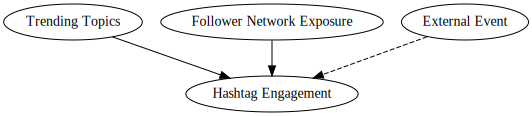

In [23]:
g = gr.Digraph(format='png')
g.edge("Trending Topics", "Hashtag Engagement")
g.edge("Follower Network Exposure", "Hashtag Engagement")
g.edge("External Event", "Hashtag Engagement", style='dashed')
g.render(os.path.join(ASSETS_DIR, 'dag_confounded'))
g

In [22]:
g = gr.Digraph(format='png')
g.edge("Trending Topics", "Hashtag Engagement")
g.edge("Follower Network Exposure", "Hashtag Engagement")
g.render(os.path.join(ASSETS_DIR, 'dag_unconfounded'))

'/home/jschless/whatsapp/data/assets/dag_unconfounded.png'

# Trending Uncertainty

In [25]:
import trending

In [30]:
ht = 'merapmmeraabhimaan'
df, trending_loc = trending.build_df(ht, campaigns[ht], exposures)

merapmmeraabhimaan trended for more than 10 hours, defaulting to only plot first 10


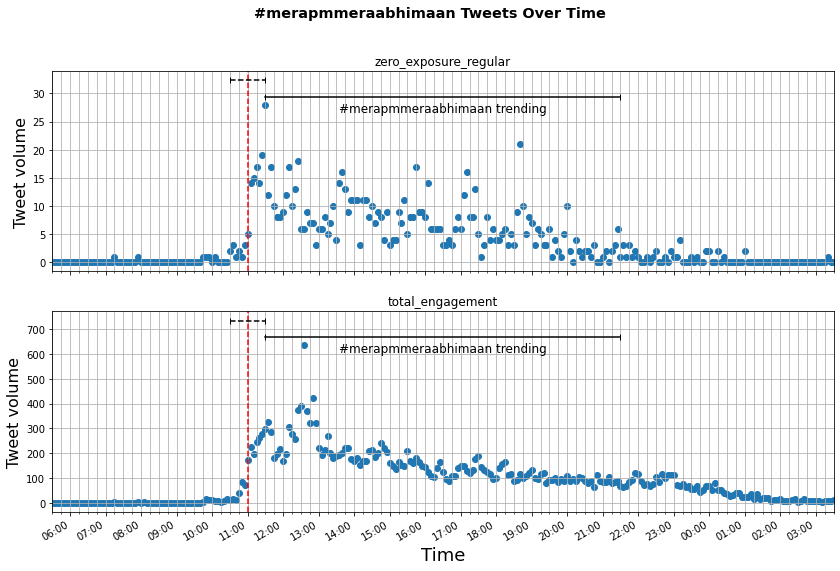

In [74]:
fig, ax = trending.plot_trending_ts(df, trending_loc, ht)


In [75]:
fig.axes[0].set(title='Zero Exposure Tweets')
fig.axes[1].set(title='Total Original Tweets')

[Text(0.5, 1.0, 'Total Original Tweets')]

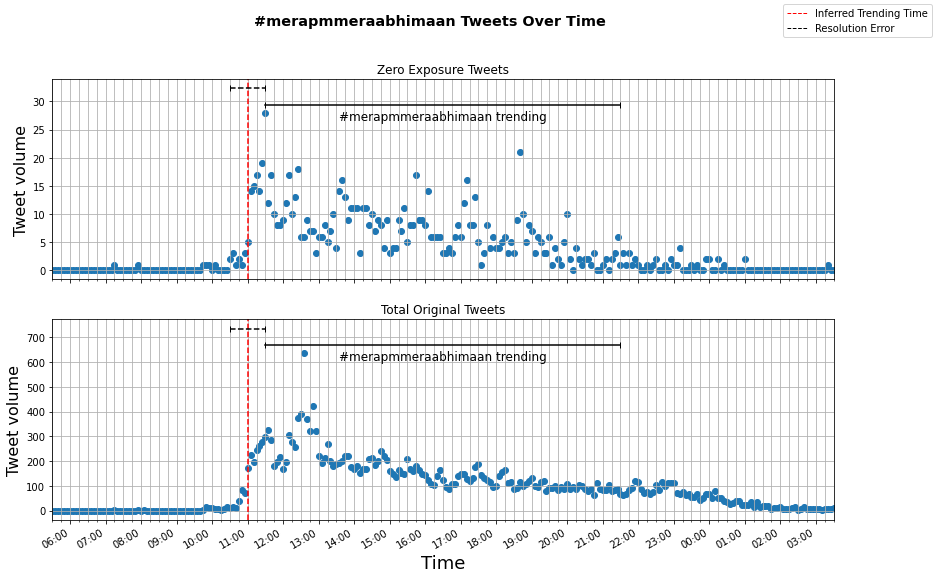

In [76]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', lw=1, ls='--'),
                Line2D([0], [0], color='black', lw=1, ls='--')]

fig.legend(custom_lines, ['Inferred Trending Time', 'Resolution Error'])
fig.savefig(os.path.join(ASSETS_DIR, 'event_study_example.png'))
fig

## Individual Level Effects

In [14]:
meta_res = []
for hashtag, tweet_dict in tqdm(campaigns.items()):
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        res = trending.run_statistics(
            *trending.build_df(hashtag, tweet_dict, exposures, time_bin='5Min', plot=False), 
                                      periods=(12,12))
        meta_res.append(pd.concat({hashtag: res}, names=['Hashtag']))

Not enough periods in df, running on model from  2019-04-22 08:35:00 to 2019-04-22 09:55:00
Not enough periods in df, running on model from  2019-01-06 17:25:00 to 2019-01-06 18:45:00
Not enough periods in df, running on model from  2019-02-13 11:25:00 to 2019-02-13 13:00:00
Not enough periods in df, running on model from  2018-12-20 19:05:00 to 2018-12-20 20:00:00
Not enough periods in df, running on model from  2018-10-17 09:30:00 to 2018-10-17 10:40:00
Not enough periods in df, running on model from  2019-04-19 15:40:00 to 2019-04-19 17:15:00
Not enough periods in df, running on model from  2019-04-17 10:45:00 to 2019-04-17 12:05:00
Not enough periods in df, running on model from  2019-03-13 20:10:00 to 2019-03-13 22:00:00
Not enough periods in df, running on model from  2018-09-14 14:40:00 to 2018-09-14 15:40:00
Not enough periods in df, running on model from  2018-09-06 12:55:00 to 2018-09-06 14:05:00
Not enough periods in df, running on model from  2019-02-23 14:05:00 to 2019-02-

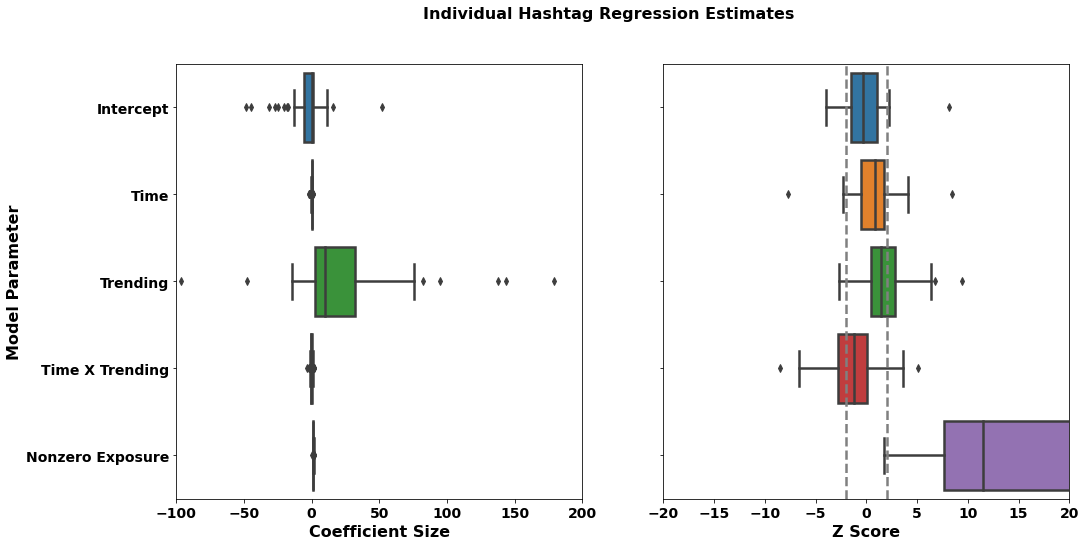

In [56]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,8))
sns.boxplot(x='coef', y='Variable', data=df, ax=ax[0])
sns.boxplot(x='z', y='Variable', data=df, ax=ax[1])
ax[1].set(xlim=(-20,20), ylabel='', xlabel='Z Score')
ax[0].set(yticklabels=['Intercept', 'Time', 'Trending', 'Time X Trending', 'Nonzero Exposure'],
          xlim=(-100,200), xlabel='Coefficient Size', ylabel='Model Parameter')
ax[1].axvline(2, color='grey', ls='--')
ax[1].axvline(-2, color='grey', ls='--')
fig.suptitle('Individual Hashtag Regression Estimates')
fig.savefig(os.path.join(ASSETS_DIR, 'inidividual_hashtag_effects.png'))

## Panel Data

In [58]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = trending.build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='5Min',
                                    cutoff_choice='best', include_missing=False)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

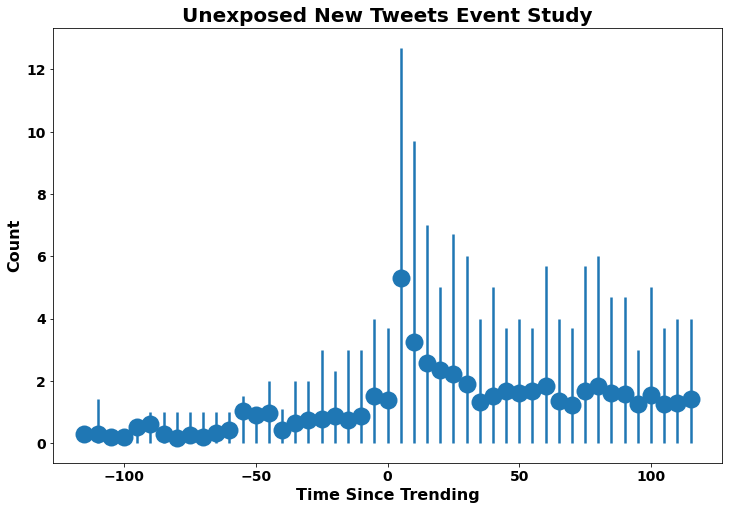

In [149]:
trending.plot_event_study(panel_df, quantiles=(.1,.9))
plt.title('Unexposed New Tweets Event Study')
plt.savefig(os.path.join(ASSETS_DIR, 'panel_event_study.png'))

In [81]:
model_results, model_names = [], []

query = panel_df.query('time >= -60 & time <= 60').fillna(0)
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()

ols = smf.ols("regular ~ time*threshold + nonzero_exposure_regular", data=query).fit(
    cov_type='cluster', cov_kwds={'groups': query['hashtag']})
model_results.append(ols)
model_names.append('OLS')

olssquare = smf.ols("regular ~ time*threshold + np.power(time,2) + nonzero_exposure_regular", data=query).fit(
    cov_type='cluster', cov_kwds={'groups': query['hashtag']})
model_results.append(olssquare)
model_names.append('OLS w/ Time Squared')

fe = smf.ols("regular ~ time*threshold + C(hashtag) + nonzero_exposure_regular", data=query).fit(
    cov_type='cluster', cov_kwds={'groups': query['hashtag']} )

model_results.append(fe)
model_names.append('Fixed Effects')

# re = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})


# model_results.append(re)
# model_names.append('Random Effects')


In [120]:
cov_names = {'threshold': 'Trending', 'time': 'Time', 'time:threshold': 'Time x Trending',
            'nonzero_exposure_regular': 'Exposed Tweets', 'np.power(time, 2)': '$\\text{Time}^2$'}

In [154]:
from stargazer import Stargazer
s = Stargazer(model_results)

In [155]:
s.covariate_order(['Intercept', 'nonzero_exposure_regular', 'threshold', 'time', 'time:threshold', 'np.power(time, 2)'])
s.rename_covariates(cov_names)

In [156]:
#s.title('Trending Topics Effects') 
s.custom_columns(model_names, [1]*len(model_names))
s.show_model_numbers(False)

In [161]:
with open(os.path.join(ASSETS_DIR, 'trending_effect_regression.tex'), 'w') as f:
    print(s.render_latex()[32:-11], file=f)

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge stargazer

Fetching package metadata ...........

PackageNotFoundError: Package missing in current linux-64 channels: 
  - stargazer

Close matches found; did you mean one of these?

    stargazer: r-stargazer, sarge, qstrader

